<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/stable_nozzle_combustion_macormack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Quasi-1D Nozzle Flow with Combustion and Artificial Dissipation
---
This notebook simulates compressible flow through a nozzle with:
- MacCormack solver
- Gaussian nozzle geometry
- Arrhenius combustion model
- Species transport ($Y_F$, $Y_P$)
- Artificial dissipation and smoothing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
gamma = 1.4
R = 287.0
nx = 500
x = np.linspace(0, 1, nx)
dx = x[1] - x[0]

# Nozzle area
epsilon = 0.5
x_t = 0.5
delta = 0.1
A = 1 + epsilon * np.exp(-((x - x_t)/delta)**2)

In [2]:
# Initial conditions
T = np.ones(nx) * 300
P = np.ones(nx) * 101325
rho = P / (R * T)
u = np.ones(nx) * 100
YF = np.ones(nx) * 0.05
YP = np.zeros(nx)
Et = rho * (R * T / (gamma - 1) + 0.5 * u**2)

In [3]:
# Parameters
q = 2e6
A_preexp = 1e6
Ea = 2e5
reaction_zone = (x > 0.45) & (x < 0.55)

# Time loop
t, t_end = 0.0, 0.0015
CFL = 0.4
eps = 0.01  # dissipation

In [4]:
for step in range(5000):
    a = np.sqrt(gamma * R * T)
    dt = CFL * dx / np.max(np.abs(u) + a)
    if t > t_end: break

    omega = A_preexp * YF * np.exp(-Ea / np.maximum(R * T, 1e-8)) * reaction_zone
    omega = np.clip(omega, 0, 1e6)

    F1 = rho * u
    F2 = rho * u**2 + P
    F3 = (Et + P) * u

    rho_p = rho - dt/dx * (np.roll(F1, -1) - F1)
    u_p = (rho * u - dt/dx * (np.roll(F2, -1) - F2)) / np.maximum(rho_p, 1e-8)
    Et_p = Et - dt/dx * (np.roll(F3, -1) - F3) + dt * q * omega * rho

    T_p = (Et_p / np.maximum(rho_p, 1e-8) - 0.5 * u_p**2) * (gamma - 1) / R
    P_p = rho_p * R * T_p

    F1_p = rho_p * u_p
    F2_p = rho_p * u_p**2 + P_p
    F3_p = (Et_p + P_p) * u_p

    rho = 0.5 * (rho + rho_p - dt/dx * (F1_p - np.roll(F1_p, 1)))
    u = 0.5 * ((rho * u + rho_p * u_p - dt/dx * (F2_p - np.roll(F2_p, 1))) / np.maximum(rho, 1e-8))
    Et = 0.5 * (Et + Et_p - dt/dx * (F3_p - np.roll(F3_p, 1))) + dt * q * omega * rho

    T = (Et / rho - 0.5 * u**2) * (gamma - 1) / R
    P = rho * R * T
    YF = np.clip(YF - dt * omega, 0, 1)
    YP = 1 - YF

    rho += eps * (np.roll(rho, -1) - 2*rho + np.roll(rho, 1))
    u += eps * (np.roll(u, -1) - 2*u + np.roll(u, 1))
    Et += eps * (np.roll(Et, -1) - 2*Et + np.roll(Et, 1))
    u = 0.5 * (np.roll(u, 1) + np.roll(u, -1))
    YF = 0.5 * (np.roll(YF, 1) + np.roll(YF, -1))
    t += dt

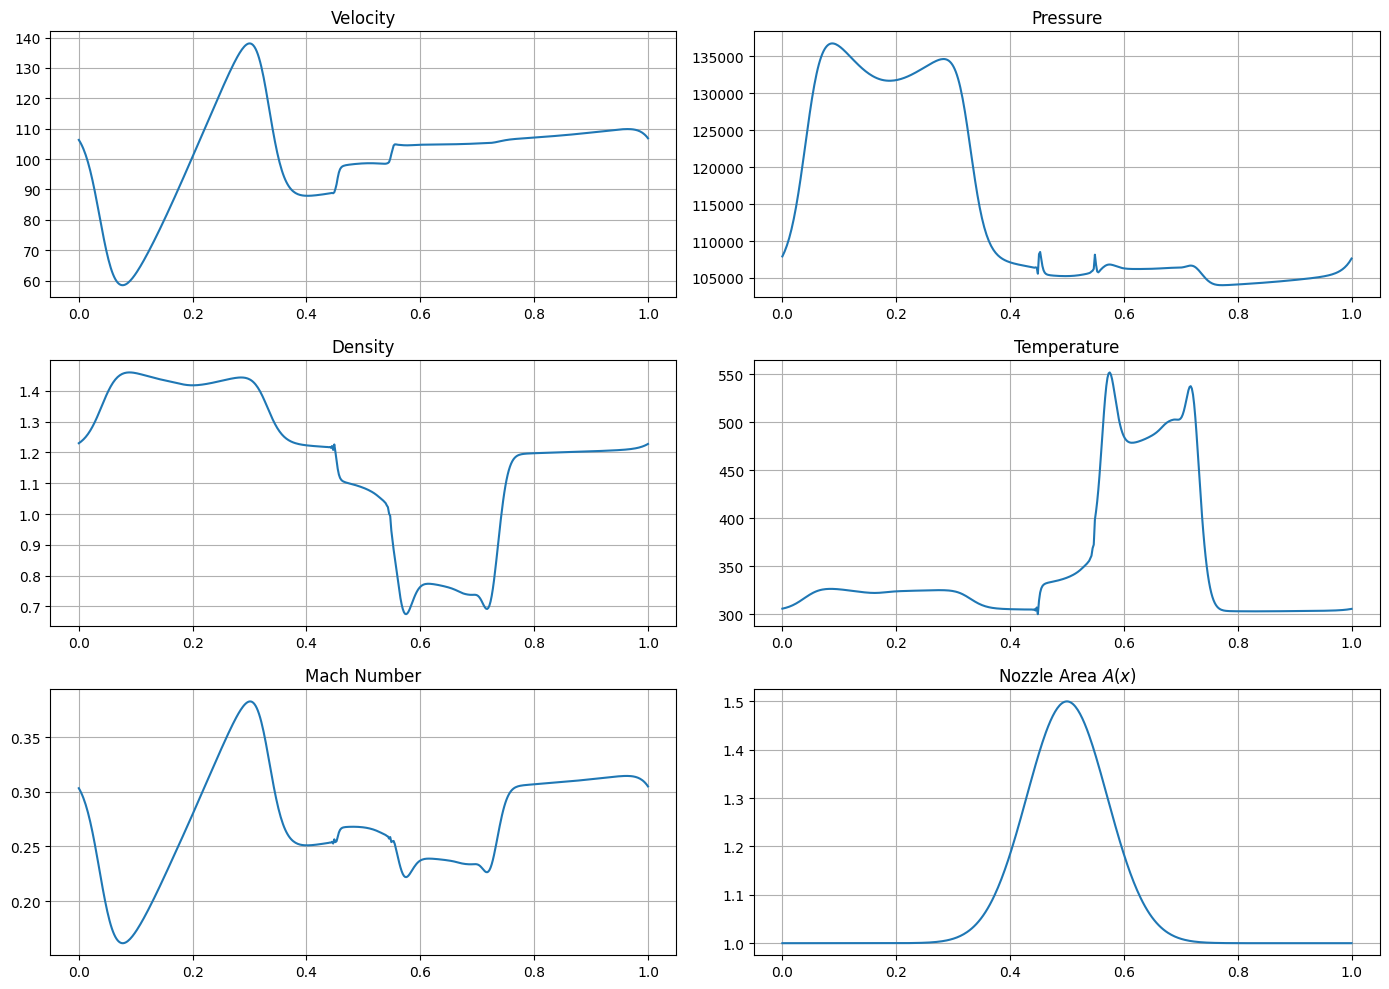

In [5]:
a = np.sqrt(gamma * R * T)
Mach = u / a

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs[0, 0].plot(x, u); axs[0, 0].set_title('Velocity')
axs[0, 1].plot(x, P); axs[0, 1].set_title('Pressure')
axs[1, 0].plot(x, rho); axs[1, 0].set_title('Density')
axs[1, 1].plot(x, T); axs[1, 1].set_title('Temperature')
axs[2, 0].plot(x, Mach); axs[2, 0].set_title('Mach Number')
axs[2, 1].plot(x, A); axs[2, 1].set_title('Nozzle Area $A(x)$')
for ax in axs.flat: ax.grid(True)
plt.tight_layout(); plt.show()